In [1]:
import pandas as pd
import numpy as np
import random as rng

from schedule import Schedule
from paintshop import PaintShop
from move import Move


# # DEBUG (reload import)
# from importlib import reload
# import paintshop
# import move
# reload(paintshop)
# reload(move)
# from paintshop import PaintShop
# from move import Move

# Settings

In [2]:
SEED = 420

# Setup

In [3]:
rng.seed(SEED)
PS = PaintShop()

# Classes

Metaheuristics:
- Multistart:  Improving multiple starts and take the best local optimum
- Taboo Search: Reverse steps are forbidden (taboo-list). Tabu moves are removed from the list after a number of moves. Stop at a certain number of iterations OR when all available moves are taboo. Keep track of incumbent solution.
- Simulated Annealing: Temperature & cooling schedule. Allways accepts improving moves. Non-improving moves with probablity based on the obj. improvement and temperature. Randomly choose a move, compute the gain. If it improves, accept, otherwise accept with probability e^(delta_obj / q). Update incumbent solution. Reduce temperature q. See graph in slides.
- Genetic algorithms: Many different ideas. Population of solutions.
   - Start with a number of random solutions.
   - Create new solutions by combining pairs.
   - Mutations sometimes.
   - Select survivors (elite).



# Solution

In [4]:
def heuristic_constructive_simple() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty schedule.
    schedule = Schedule()
    
    # For each order.
    for order_id in PS.order_ids:
        
        # Determine machine index with the shortest queue (adding a machine's index (scaled to a fraction) works like the tiebreaking rule).
        machine_id_next = sorted(
            PS.machine_ids, 
            key = lambda i:
                len(schedule[i, :]) +
                i / len(PS.machine_ids)
        )[0]
        
        # Add order to machine queue.
        schedule[machine_id_next, :] += [order_id]
        
    return schedule


print(heuristic_constructive_simple())

       0   1   2   3   4   5   6   7   8   9   1414.11
M1: [  0   3   6   9  12  15  18  21  24  27 ] 565.00 (40%)
M2: [  1   4   7  10  13  16  19  22  25  28 ] 222.00 (16%)
M3: [  2   5   8  11  14  17  20  23  26  29 ] 627.11 (44%)


In [5]:
def heuristic_constructive_simple_2() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    # For each order (ordered by order-number ascending).
    for order_id in PS.order_ids:
        
        # Determine machine index with the shortest queue (adding a machine's index (scaled to a fraction) works like the tiebreaking rule).
        machine_id_next = sorted(
            PS.machine_ids, 
            key = lambda i:
                schedule.get_finish_time(i) + 
                i / len(PS.machine_ids), 
        )[0]
        
        # Add order to machine queue.
        schedule[machine_id_next, :] += [order_id]
        
    return schedule

In [6]:

def heuristic_constructive_simple_3() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    # For each order (ordered by order-number ascending).
    for order_id in sorted(PS.order_ids, key = lambda order_id: PS.orders.loc[order_id, 'deadline']):
        
        # Determine machine index with the shortest queue (adding a machine's index (scaled to a fraction) works like the tiebreaking rule).
        machine_id_next = sorted(
            PS.machine_ids, 
            key = lambda i:
                schedule.get_finish_time(i) + 
                i / len(PS.machine_ids), 
        )[0]
        
        # Add order to machine queue.
        schedule[machine_id_next, :] += [order_id]
        
    return schedule

In [7]:

import copy


def heuristic_constructive_random() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    # Create list of shuffled order ID's
    order_ids_remaining = copy.copy(PS.order_ids)
    rng.shuffle(order_ids_remaining)
    
    while len(order_ids_remaining) > 0:
        
        next_order_id_index = rng.choice(range(len(order_ids_remaining)))
        
        schedule[rng.choice(PS.machine_ids), :] += [order_ids_remaining[next_order_id_index]]
        
        order_ids_remaining = np.delete(order_ids_remaining, next_order_id_index)     
         
    return schedule

In [27]:
def heuristic_improvement_best(initial: Schedule) -> Schedule:
    
    # Initialize incumbent solution
    current_schedule = initial
    print(f"Initial:\n{current_schedule}\n")
    
    # Loop until local optimum found
    while True:
        
        # Variables to keep track of best move
        best_move = None
        best_move_cost = current_schedule.get_cost()
        
        # Loop over all possible moves
        moves: list[Move] = Move.get_moves(current_schedule) # Variable assignment is only for the type hint
        for move in moves:
            
            # Get the moved schedule
            moved_schedule = move.get_moved(current_schedule)
            moved_cost = moved_schedule.get_cost()
            
            # Keep track of best move
            if (moved_cost < best_move_cost):
                best_move = move
                best_move_cost = moved_cost
        
        # Break the loop if no improving swap was found.
        if best_move == None:
            print(f'No improving moves found.')
            break
        
        # Update and print incumbent solution
        current_schedule = best_move.get_moved(current_schedule)
        print(f'{best_move}\n{current_schedule}\n')
    
    # Return incument solution
    return current_schedule


s = heuristic_improvement_best(heuristic_constructive_random())

Initial:
       0   1   2   3   4   5   6   7   8   9  10  11  12   8579.28
M1: [ 15  18  13   8  10  27  24  29  28  16             ] 2902.50 (34%)
M2: [ 21   1  22   7   6   3  12  25  19  23   0   2  26 ] 4711.00 (55%)
M3: [ 17  14   5   4   9  20  11                         ] 965.78  (11%)

swap-items: (0, 2) <=> (1, 2)
       0   1   2   3   4   5   6   7   8   9  10  11  12   5296.08
M1: [ 15  18  22   8  10  27  24  29  28  16             ] 1386.50 (26%)
M2: [ 21   1  13   7   6   3  12  25  19  23   0   2  26 ] 2943.80 (56%)
M3: [ 17  14   5   4   9  20  11                         ] 965.78  (18%)

swap-items: (0, 4) <=> (1, 0)
       0   1   2   3   4   5   6   7   8   9  10  11  12   4380.58
M1: [ 15  18  22   8  21  27  24  29  28  16             ] 548.00  (13%)
M2: [ 10   1  13   7   6   3  12  25  19  23   0   2  26 ] 2866.80 (65%)
M3: [ 17  14   5   4   9  20  11                         ] 965.78  (22%)

swap-items: (0, 2) <=> (1, 11)
       0   1   2   3   4   5   6   7   

In [98]:
def get_first_improvement(schedule: Schedule) -> Move:
    
    # Calculate current cost
    current_cost = schedule.get_cost()
    
    # Loop over all possible moves
    moves: list[Move] = Move.get_moves(schedule) # Variable assignment is only for the type hint
    for move in moves:
        
        # Get the moved schedule.
        moved_schedule = move.get_moved(schedule)
        moved_penalty = moved_schedule.get_cost()
        
        # Return improving move if found.
        if (moved_penalty < current_cost):
            return move
    
    # Return none because no improving feasible solution found
    return None

In [99]:
def get_best_improvement(schedule: Schedule) -> Move:
    
    # Calculate current cost
    current_cost = schedule.get_cost()
    
    # Keep track of best move
    best_move = None
    best_move_cost = current_cost
    
    # Loop over all possible moves
    moves: list[Move] = Move.get_moves(schedule) # Variable assignment is only for the type hint
    for move in moves:
        
        # Get the moved schedule & cost
        moved_schedule = move.get_moved(schedule)
        moved_penalty = moved_schedule.get_cost()
        
        # Keep track of best improving move
        if (moved_penalty < best_move_cost):
            best_move = move
            best_move_cost = moved_penalty
            
    # Return best move (can be None)
    return best_move

In [ ]:
# def heuristic_improvement_first(schedule: Schedule) -> Schedule:
    
#     # Loop until local optimum found
#     while True:
        
#         # Get the first improving feasible move
#         (move, moved_schedule, moved_penalty) = get_first_improvement(current_schedule)
        
#         # Break the loop if no improving move was found.
#         if move is None:
#             print(f'No improving moves found.')
#             break
                
#         # Update and print incumbent solution
#         current_schedule = moved_schedule
#         print(f'{move}\n{current_schedule}\n')
    
#     # Return incument solution
#     return current_schedule

In [103]:
import math
import time
from typing import Callable

def heuristic_improvement_comparison_multistart(n_starts, get_improvement_func: Callable[[Schedule], Move]) -> list[dict]:
    
    # Generate n_starts random feasible solutions, initialize a list of dictionaries to keep track of things.
    runs_data = [{
        "current_schedule": schedule,
        "penalties": [schedule.get_cost()],
        "moves": [],
        "done": False,
        "times": []
    } for schedule in [
        heuristic_constructive_random() for _ in range(n_starts)
    ]]
    
    print(f"Generated {n_starts} random schedules.")
    
    # Heuristic loop
    iteration_count = 0
    any_improvement_found = True
    while any_improvement_found:
        
        any_improvement_found = False
        iteration_count += 1
        
        # For each run
        for run_index in range(n_starts):
            
            # If the run is done, 
            if runs_data[run_index]["done"]:
                
                # Add previous penalty & continue
                runs_data[run_index]["penalties"] += [runs_data[run_index]["penalties"][-1]]
                continue
            
            t0 = time.time()
            
            # Get the first improving feasible move
            move = get_improvement_func(runs_data[run_index]["current_schedule"])
            
            
            
            
            processing_time = time.time() - t0
            
            # Add penalty and processing time -- even if no improvement found
            
            runs_data[run_index]["times"] += [processing_time]
            
            # If no improvement: continue
            if move is None:
                runs_data[run_index]["done"] = True
                runs_data[run_index]["penalties"] += [runs_data[run_index]["penalties"][-1]]
                continue
            
            
            moved_schedule = move.get_moved(runs_data[run_index]["current_schedule"])
            moved_penalty = moved_schedule.get_cost()
            
            runs_data[run_index]["penalties"] += [moved_penalty]
            
            # Update schedule, save move, note that improvement was found
            runs_data[run_index]["current_schedule"] = moved_schedule
            runs_data[run_index]["moves"] += [move]
            any_improvement_found = True
        
        # Print progress
        cur_penalties = [data['penalties'][-1] for data in runs_data]
        cur_times = [data['times'][-1] for data in runs_data]
        print(f"{iteration_count}: {sum([1 for run in runs_data if not run['done']])}/{n_starts} | {np.mean(cur_penalties):.0f} ± {np.std(cur_penalties):.0f} ({sum(cur_times):.2f}s)")
    
    # Print completion
    print(f'No improving moves found.')
    return (iteration_count, runs_data)

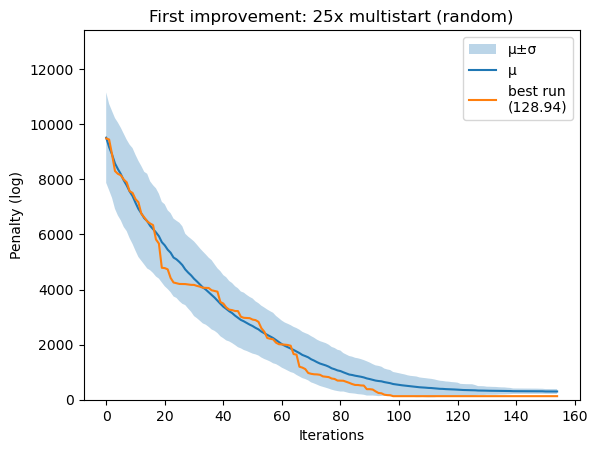

In [95]:
import matplotlib.pyplot as plt
def plot_multistart(iter_count, runs):
    

    iterations = range(iter_count + 1)

    penalty_means = np.array([
        np.mean([
            run["penalties"][i] for run in runs
        ]) for i in iterations
    ])
    penalty_stds = np.array([
        np.std([
            run["penalties"][i] for run in runs
        ]) for i in iterations
    ])

    best_run = sorted(runs, key = lambda run: run["penalties"][-1])[0]

    plt.figure()
    plt.fill_between(iterations, penalty_means - penalty_stds, penalty_means + penalty_stds, alpha = 0.3, label = "μ±σ")
    plt.plot(iterations, penalty_means, label='μ')
    plt.plot(iterations, best_run["penalties"], label = f"best run\n({best_run['penalties'][-1]:.2f})")
    plt.title(f"First improvement: {len(runs)}x multistart (random)")
    plt.legend()
    # plt.yscale('log')
    plt.ylim(0, max([run["penalties"][0] for run in runs]))
    plt.ylabel("Penalty (log)")
    plt.xlabel("Iterations")
    plt.show()
    

In [ ]:
n_starts = 25
(iter_count, runs) = heuristic_improvement_comparison_multistart(n_starts, get_first_improvement)
plot_multistart(iter_count, runs)

Generated 25 random schedules.
1: 25/25 | 7894 ± 2313 (76.42s)
2: 25/25 | 6455 ± 1857 (74.92s)
3: 25/25 | 5372 ± 1619 (73.81s)
4: 25/25 | 4477 ± 1381 (76.98s)
5: 25/25 | 3729 ± 1171 (77.23s)
6: 25/25 | 3121 ± 1035 (78.48s)
7: 25/25 | 2640 ± 872 (77.62s)
8: 25/25 | 2264 ± 728 (78.96s)
9: 25/25 | 1928 ± 612 (77.77s)
10: 25/25 | 1652 ± 513 (77.57s)
11: 25/25 | 1448 ± 451 (76.31s)
12: 25/25 | 1252 ± 386 (80.19s)
13: 25/25 | 1095 ± 342 (76.35s)
14: 25/25 | 972 ± 312 (74.74s)
15: 25/25 | 863 ± 288 (73.69s)
16: 25/25 | 775 ± 272 (73.52s)
17: 25/25 | 687 ± 252 (73.77s)
18: 25/25 | 614 ± 242 (75.07s)
19: 25/25 | 560 ± 236 (75.74s)
20: 25/25 | 509 ± 224 (75.29s)
21: 24/25 | 464 ± 215 (75.93s)
22: 24/25 | 434 ± 200 (73.51s)
23: 23/25 | 406 ± 186 (75.47s)
24: 19/25 | 381 ± 175 (74.54s)
25: 15/25 | 364 ± 167 (76.55s)
26: 14/25 | 357 ± 165 (75.25s)
27: 12/25 | 351 ± 163 (75.55s)
28: 7/25 | 344 ± 161 (75.35s)
29: 6/25 | 339 ± 158 (76.40s)
30: 5/25 | 337 ± 153 (76.87s)
31: 3/25 | 335 ± 147 (76.81s)
32

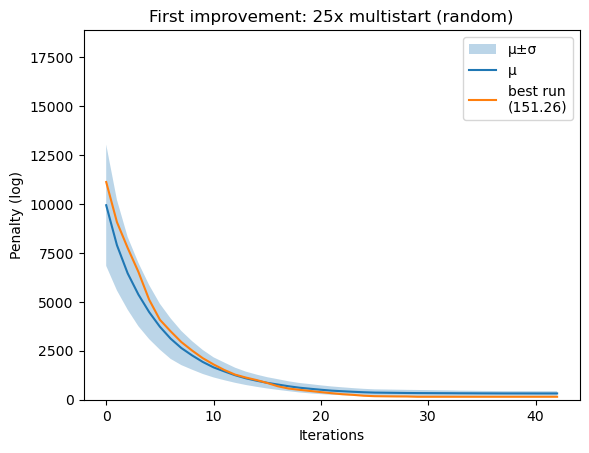

In [106]:
n_starts = 25
(iter_count, runs) = heuristic_improvement_comparison_multistart(n_starts, get_best_improvement)
plot_multistart(iter_count, runs)

In [105]:
sum([sum(run["times"]) for run in runs])

241.0545516014099

### Constructive heuristics

In [21]:
print('\n\n'.join([
    f"{schedule}" for heuristic, schedule in {
        "constructive_simple": heuristic_constructive_simple(),
        "constructive_simple_2": heuristic_constructive_simple_2(),
        "constructive_simple_3": heuristic_constructive_simple_3(),
        "constructive_random": heuristic_constructive_random()
    }.items()
]))

       0   1   2   3   4   5   6   7   8   9   1414.11
M1: [  0   3   6   9  12  15  18  21  24  27 ] 565.00 (40%)
M2: [  1   4   7  10  13  16  19  22  25  28 ] 222.00 (16%)
M3: [  2   5   8  11  14  17  20  23  26  29 ] 627.11 (44%)

       0   1   2   3   4   5   6   7   8   9  10  11   2815.77
M1: [  0   3   7  12  14  17  20  22  25  29         ] 760.50  (27%)
M2: [  1   4   6   9  10  13  15  19  21  24  26  28 ] 1440.60 (51%)
M3: [  2   5   8  11  16  18  23  27                 ] 614.67  (22%)

       0   1   2   3   4   5   6   7   8   9  10   4181.39
M1: [  2  10   6   7  13  19  18  16  28  23     ] 1632.50 (39%)
M2: [  3  11   8   4  12  15  14  26  25  21  29 ] 1445.00 (35%)
M3: [  0   1   5   9  24  20  17  27  22         ] 1103.89 (26%)

       0   1   2   3   4   5   6   7   8   9  10  11   9398.88
M1: [  0   9  20  17   1   2  10   8  13  27   3     ] 6387.50 (68%)
M2: [ 19  25  26   4  18   5  28  16   6  29  23  14 ] 2156.60 (23%)
M3: [  7  21  22  15  24  11  12     

# Code Validation

In [12]:
import itertools as iter

### Move-set redundancy
Ensuring that no two moves produce the same moved schedules.

In [13]:
# Generate and display a random schedule
s = heuristic_constructive_random()
print(s)

# Generate all possible moves and print the amount
moves: list[Move] = Move.get_moves(s)
print(f'\nAmount of moves: {len(moves)}')

# Generate the moved schedules for all the moves
moved_schedules = [move.get_moved(s) for move in moves]
print(f"\nMoves that do nothing: {sum([(s == moved_s) for moved_s in moved_schedules])}")

# Display the amount of unique moved schedules
print(f'\nUnique schedules after moves: {len(set(moved_schedules))}')

# Create a dictionary of moves by the hash-code of the moved schedule that they produce
by_hash = {}
for move in moves:
    
    # Get moved schedule
    moved = move.get_moved(s)
    
    # Get hash-code
    hash_code = hash(moved)
    
    # Add move if hash-code exists in dict, else: add it.
    if hash_code in by_hash.keys():
        by_hash[hash_code]["moves"] += [move]
    else:
        by_hash[hash_code] = {
            "moves": [move],
            "schedule": moved
        }
        
# Display all the non-unique moved schedules along with their moves
for hash_code, data in [(hash_code, data) for hash_code, data in by_hash.items() if len(data["moves"]) > 1]:
    print()
    print(data["schedule"])
    for move in data["moves"]:
        print(move)

       0   1   2   3   4   5   6   7   8   9  10   11034.53
M1: [  5   4  26   3  10  27  14  11   0   7     ] 4507.00 (41%)
M2: [ 16  22  23  20   1  21  12  18  17         ] 1047.20 (9%)
M3: [ 15  19   8  28  24   9  13   2   6  25  29 ] 5480.33 (50%)

Amount of moves: 900

Moves that do nothing: 0

Unique schedules after moves: 900
